# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Fire Perimeters Processing

BrainStation Winter 2023: Data Science

In [2]:
# imports

import numpy as np
import pandas as pd
import geopandas as gpd

In [32]:
perim_year=gpd.read_file('/Users/sra/Files/brainstation_2023_ds_capstone/brainstation_2023_ds_capstone/01_capstone_data/shapefiles/perimeters_sm/santa_monica_fire_perimeters.geojson')

perim_year.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,geometry
0,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,Wildfire,747.898400,None,CalFire FRAP,LRA,2007,4.427910e+06,15010.918614,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
1,4752,Mixed Collection Methods,20070331,"NPS from BARC, air photo interp. Presumed accu...",21991,None,2007-CALAC-00000000,2007,00000000,BARHAM,...,None,Wildfire,224.327600,None,CalFire FRAP,LRA,2007,1.328556e+06,6131.239501,"MULTIPOLYGON (((-118.32768 34.14417, -118.3276..."
2,4753,Photo Interpretation,20070814,"perim = 5ac circle, by NPS, from oblique air p...",22008,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,Wildfire,4.961969,None,CalFire FRAP,LRA,2007,2.937153e+04,607.790204,"MULTIPOLYGON (((-118.30536 34.11951, -118.3053..."
3,4767,GPS Ground,20050629,None,23059,None,2005-CAVNC-00000004,2005,00000004,FREEWAY,...,None,Wildfire,14.858700,None,CalFire FRAP,LRA,2005,8.806273e+04,2377.683184,"MULTIPOLYGON (((-118.84353 34.16950, -118.8435..."
4,4774,GPS Air,20060708,None,37343,None,2006-CAVNC-06060649,2006,06060649,SHERWOOD,...,None,Wildfire,167.956900,None,CalFire FRAP,LRA,2006,9.945188e+05,4803.805347,"MULTIPOLYGON (((-118.85184 34.13559, -118.8516..."


In [35]:
perim_geomac=gpd.read_file('/Users/sra/Desktop/Data_Science_2023/_capstone/1.capstone_data/fire_data/perimeters/Historic Perimeters Combined 2000-2018 GeoMAC/Historic_Perimeters_Combined_2000-2018_GeoMAC.geojson')
perim_geomac.head()

,OBJECTID,agency,comments,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,perimeterdatetime,...,pooresponsibleunit,state,inciwebid,localincidentidentifier,irwinid,incomplex,complexfirecode,SHAPE_Length,SHAPE_Area,geometry
0,1,USFS,WFDSS,GPS-Walked/ Driven,2018-02-14T00:00:00+00:00,2018-AZCNF-000059,2018,BOX,AZCNF,2018-02-12T17:00:00+00:00,...,AZCNF,AZ,None,000059,{9A5CFD7A-5C05-40E6-A617-088B44A41174},N,None,0.025799,3.072046e-05,"MULTIPOLYGON (((-110.84899 31.77031, -110.8493..."
1,2,USFS,WFDSS,GPS-Walked/ Driven,2018-04-06T00:00:00+00:00,2018-AROUF-000688,2018,Zoe,AROUF,2018-04-05T00:00:00+00:00,...,AROUF,OK,None,000688,{5AFC28D0-6193-4103-AE00-65F4E659CA55},N,None,0.001289,8.045641e-08,"MULTIPOLYGON (((-94.57675 34.78029, -94.57685 ..."
2,3,C&L,WFDSS,Hand Sketch,2017-04-24T00:00:00+00:00,2017-CORBX-000061,2017,Milemarker 24,None,2017-04-21T00:00:00+00:00,...,CORBX,CO,None,000061,{9C1A9E10-8FA8-4166-A212-EAF39A860469},N,None,0.037537,3.542421e-05,"MULTIPOLYGON (((-107.59472 40.00728, -107.5946..."
3,4,BLM,None,GPS-Walked,2017-07-13T00:00:00+00:00,2017-IDIFD-017076,2017,Buffalo Jump,None,2017-06-25T00:00:00+00:00,...,IDIFD,ID,None,017076,{833B0C23-A630-4181-A76C-3451386E970E},N,None,0.013583,2.506614e-06,"MULTIPOLYGON (((-114.22769 44.44964, -114.2276..."
4,5,DFR,WFDSS; This is a heads up drawing based on EGP...,Image Interpretation,2017-02-06T00:00:00+00:00,2017-NCNCS-170004,2017,SUGAR COVE,NCNCS,2017-01-30T00:00:00+00:00,...,NCNCS,NC,None,170004,{76278212-B950-430A-8042-4F8C239DCEA2},N,None,0.026399,5.110220e-05,"MULTIPOLYGON (((-82.14783 35.74547, -82.14921 ..."


In [33]:
perim_year['FIRE_YEAR'].value_counts()

2007    74
2015    56
2013    40
2014    39
2016    32
        ..
1964     2
1962     2
1930     2
1932     2
1971     2
Name: FIRE_YEAR, Length: 89, dtype: int64

In [39]:
perim_geomac['fireyear'].value_counts()

2011    2996
2017    1702
2018    1618
2006    1510
2012    1466
2007    1440
2015    1294
2005    1256
2016    1179
2008    1154
2000    1123
2010    1030
2013     997
2001     918
2003     915
2009     867
2002     866
2014     750
2004     695
Name: fireyear, dtype: int64

In [36]:
# does perim_year and perim_geomac have the same data?
perim_year_geomac=pd.merge(perim_geomac,perim_year,how='left',on='uniquefireidentifier')
perim_year_geomac

# this will throw an error
# we have to rename the UNQE_FIRE_ column 
# to match the uniquefireidentifier

# but first, let's see if the unique fire identifiers are the same

KeyError: 'uniquefireidentifier'

In [40]:
perim_year['UNQE_FIRE_'].value_counts()

00000000               264
1975-CALAC-00000000     13
1972-CALAC-00000000     10
1978-CALAC-00000000     10
1956-CALAC-00000000      9
                      ... 
2021-CALAC-00211043      1
2021-CALAC-00223635      1
2021-CALAC-00009554      1
2020-CALAC-00307499      1
2018-CALFD-000934        1
Name: UNQE_FIRE_, Length: 495, dtype: int64

In [41]:
perim_geomac['uniquefireidentifier'].value_counts()

2011-TXTXS            1405
2003-CA                252
2002-CA                227
2005-CA                 93
2002-AK-                80
                      ... 
2011-MTMCD-000056        1
2017-NVELD-040067        1
2011-MTBID-000017        1
2011-MTMCD-000014        1
2014-OR722S-000150       1
Name: uniquefireidentifier, Length: 19545, dtype: int64

In [42]:
perim_geomac[perim_geomac['uniquefireidentifier']=='2021-CALAC-00223635']

,OBJECTID,agency,comments,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,perimeterdatetime,...,pooresponsibleunit,state,inciwebid,localincidentidentifier,irwinid,incomplex,complexfirecode,SHAPE_Length,SHAPE_Area,geometry


In [37]:
perim_year.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1084 non-null   int64   
 1   MAP_METHOD  310 non-null    object  
 2   DATE_CUR    1067 non-null   object  
 3   COMMENTS    364 non-null    object  
 4   GEO_ID      1076 non-null   object  
 5   IRWINID     43 non-null     object  
 6   UNQE_FIRE_  982 non-null    object  
 7   FIRE_YEAR   1084 non-null   object  
 8   LOCAL_NUM   456 non-null    object  
 9   INCIDENT    741 non-null    object  
 10  UNIT_ID     1015 non-null   object  
 11  POO_RESP_I  162 non-null    object  
 12  FEATURE_CA  1024 non-null   object  
 13  GIS_ACRES   1076 non-null   float64 
 14  USER_NAME   190 non-null    object  
 15  SOURCE      1084 non-null   object  
 16  AGENCY      1067 non-null   object  
 17  FIRE_YEAR_  1084 non-null   int64   
 18  Shape__Are  1084 non-null   float64 
 19

In [38]:
perim_geomac.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23776 entries, 0 to 23775
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   OBJECTID                 23776 non-null  int64   
 1   agency                   23776 non-null  object  
 2   comments                 13345 non-null  object  
 3   mapmethod                22158 non-null  object  
 4   datecurrent              21668 non-null  object  
 5   uniquefireidentifier     23776 non-null  object  
 6   fireyear                 23776 non-null  int64   
 7   incidentname             23627 non-null  object  
 8   pooownerunit             3872 non-null   object  
 9   perimeterdatetime        23775 non-null  object  
 10  gisacres                 23776 non-null  float64 
 11  complexname              2275 non-null   object  
 12  firecode                 14269 non-null  object  
 13  complexparentirwinid     562 non-null    object  
 14

In [43]:
perim_year.rename(columns={'UNQE_FIRE_':'uniquefireidentifier'},inplace=True)

In [44]:
perim_year_geomac=pd.merge(perim_geomac,perim_year,how='left',on='uniquefireidentifier')
perim_year_geomac

,OBJECTID_x,agency,comments,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,perimeterdatetime,...,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,geometry_y
0,1,USFS,WFDSS,GPS-Walked/ Driven,2018-02-14T00:00:00+00:00,2018-AZCNF-000059,2018,BOX,AZCNF,2018-02-12T17:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2,USFS,WFDSS,GPS-Walked/ Driven,2018-04-06T00:00:00+00:00,2018-AROUF-000688,2018,Zoe,AROUF,2018-04-05T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,3,C&L,WFDSS,Hand Sketch,2017-04-24T00:00:00+00:00,2017-CORBX-000061,2017,Milemarker 24,None,2017-04-21T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,4,BLM,None,GPS-Walked,2017-07-13T00:00:00+00:00,2017-IDIFD-017076,2017,Buffalo Jump,None,2017-06-25T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,5,DFR,WFDSS; This is a heads up drawing based on EGP...,Image Interpretation,2017-02-06T00:00:00+00:00,2017-NCNCS-170004,2017,SUGAR COVE,NCNCS,2017-01-30T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23771,23772,USFS,None,Unknown,2014-08-15T00:00:00+00:00,2014-CAKNF-005564,2014,Waterfall,None,2014-08-15T02:45:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
23772,23773,USFS,None,Unknown,2014-09-09T00:00:00+00:00,2014-CAKNF-006001,2014,Jackson,None,2014-09-08T21:21:59+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
23773,23774,USFS,None,Unknown,2014-07-23T00:00:00+00:00,2014-CAMDF-000344,2014,Lake,None,2014-07-08T05:52:59+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
23774,23775,USFS,IR heat perimeter; no entry in FireCode,Infrared Image,2014-09-25T00:00:00+00:00,2014-IDNCF-000675,2014,Crew Creek,None,2014-09-23T21:59:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [45]:
perim_year_geomac.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23776 entries, 0 to 23775
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   OBJECTID_x               23776 non-null  int64   
 1   agency                   23776 non-null  object  
 2   comments                 13345 non-null  object  
 3   mapmethod                22158 non-null  object  
 4   datecurrent              21668 non-null  object  
 5   uniquefireidentifier     23776 non-null  object  
 6   fireyear                 23776 non-null  int64   
 7   incidentname             23627 non-null  object  
 8   pooownerunit             3872 non-null   object  
 9   perimeterdatetime        23775 non-null  object  
 10  gisacres                 23776 non-null  float64 
 11  complexname              2275 non-null   object  
 12  firecode                 14269 non-null  object  
 13  complexparentirwinid     562 non-null    object  
 14

In [ ]:
# this means that the perim_year dataset has 
# different fires than the perim_geomac dataset.
# because the perim_geomac dataset has dates 
# for the fires, I will use that for my analysis.

In [2]:
perim_join=gpd.read_file('/Users/sra/Desktop/Data_Science_2023/_capstone/1.capstone_data/sm_elevasp_perim_join_contain.geojson')
perim_join.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,_perimid,_perimelevation_1,_perimaspect_1,geometry
0,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1644.0,434.0,31.883564,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
1,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1645.0,349.0,7.624194,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
2,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1646.0,288.0,72.613029,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
3,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1647.0,189.0,335.170654,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
4,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1648.0,229.0,346.464142,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."


In [3]:
perim_join.rename(columns={'_perimid':'point_id',
                           '_perimelevation_1':'point_elevation',
                           '_perimaspect_1':'point_aspect'},
                  inplace=True)
perim_join.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,point_id,point_elevation,point_aspect,geometry
0,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1644.0,434.0,31.883564,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
1,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1645.0,349.0,7.624194,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
2,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1646.0,288.0,72.613029,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
3,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1647.0,189.0,335.170654,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
4,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4427910.25,15010.918614,1648.0,229.0,346.464142,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."


In [4]:
perim_join.sort_values(by=['point_id'])
perim_join

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,point_id,point_elevation,point_aspect,geometry
0,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4.427910e+06,15010.918614,1644.0,434.0,31.883564,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
1,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4.427910e+06,15010.918614,1645.0,349.0,7.624194,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
2,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4.427910e+06,15010.918614,1646.0,288.0,72.613029,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
3,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4.427910e+06,15010.918614,1647.0,189.0,335.170654,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
4,4751,Mixed Collection Methods,20070508,NPS from BARC imagery and air photo interp. Pr...,21990,None,2007-CALAC-00000000,2007,00000000,GRIFFITH PARK,...,None,CalFire FRAP,LRA,2007,4.427910e+06,15010.918614,1648.0,229.0,346.464142,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17082,125664,Hand Sketch,None,Created by InFORM Inspector,None,{6F7D742B-E785-4CDA-9CA4-957AAC39C62B},2021-CALAC-344631,2021,344631,STUNT,...,None,WFIGS,C&L,2021,1.916547e+03,216.436749,NaN,NaN,NaN,"MULTIPOLYGON (((-118.67324 34.06533, -118.6732..."
17083,125665,Hand Sketch,None,Created by InFORM Inspector,None,{01B40D30-5E94-440A-90EA-D2DEC701C03A},2021-CAVNC-087178,2021,087178,LYNN,...,None,WFIGS,None,2021,3.752109e+02,102.076018,NaN,NaN,NaN,"MULTIPOLYGON (((-118.98693 34.15249, -118.9869..."
17084,125667,Mixed Methods,202201080006,Created by InFORM Inspector,None,{DE819F3A-2DEC-45E6-9AC0-A1D1CC1CBBBD},2021-CALAC-328501,2021,328501,COLD IC,...,None,WFIGS,C&L,2021,2.857945e+03,189.751298,NaN,NaN,NaN,"MULTIPOLYGON (((-118.66184 34.11686, -118.6617..."
17085,125668,Mixed Methods,202201080236,Created by InFORM Inspector,None,{7A1FC3CB-495B-495B-9AA9-069A640D9F4F},2021-CALAC-381519,2021,381519,LAC-381519,...,None,WFIGS,C&L,2021,8.439844e+01,32.608910,NaN,NaN,NaN,"MULTIPOLYGON (((-118.58917 34.04037, -118.5891..."


In [5]:
# what are the NaNs? This is disturbing.
perim_join['point_id']

0        1644.0
1        1645.0
2        1646.0
3        1647.0
4        1648.0
          ...  
17082       NaN
17083       NaN
17084       NaN
17085       NaN
17086       NaN
Name: point_id, Length: 17087, dtype: float64

In [6]:
perim_join['point_id'].isna().sum()
# 641 NaNs in the dataset

641

<Axes: >

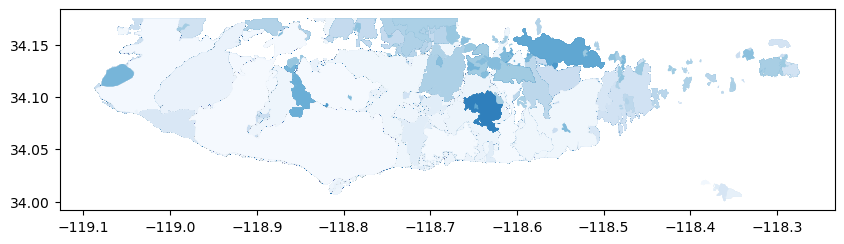

In [7]:
perim_join.plot("point_elevation", cmap="Blues",figsize=(10,10))  

In [8]:
perim_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17087 entries, 0 to 17086
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   OBJECTID         17087 non-null  int64   
 1   MAP_METHOD       3119 non-null   object  
 2   DATE_CUR         16973 non-null  object  
 3   COMMENTS         3241 non-null   object  
 4   GEO_ID           17079 non-null  object  
 5   IRWINID          43 non-null     object  
 6   UNQE_FIRE_       16270 non-null  object  
 7   FIRE_YEAR        17087 non-null  object  
 8   LOCAL_NUM        8375 non-null   object  
 9   INCIDENT         15678 non-null  object  
 10  UNIT_ID          16958 non-null  object  
 11  POO_RESP_I       837 non-null    object  
 12  FEATURE_CA       16644 non-null  object  
 13  GIS_ACRES        17079 non-null  float64 
 14  USER_NAME        925 non-null    object  
 15  SOURCE           17087 non-null  object  
 16  AGENCY           17070 non-null 

In [11]:
perim_join_clean=perim_join[['OBJECTID','FIRE_YEAR','FIRE_YEAR_','point_id','point_elevation','point_aspect','geometry']]
perim_join_clean

,OBJECTID,FIRE_YEAR,FIRE_YEAR_,point_id,point_elevation,point_aspect,geometry
0,4751,2007,2007,1644.0,434.0,31.883564,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
1,4751,2007,2007,1645.0,349.0,7.624194,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
2,4751,2007,2007,1646.0,288.0,72.613029,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
3,4751,2007,2007,1647.0,189.0,335.170654,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
4,4751,2007,2007,1648.0,229.0,346.464142,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
...,...,...,...,...,...,...,...
17082,125664,2021,2021,NaN,NaN,NaN,"MULTIPOLYGON (((-118.67324 34.06533, -118.6732..."
17083,125665,2021,2021,NaN,NaN,NaN,"MULTIPOLYGON (((-118.98693 34.15249, -118.9869..."
17084,125667,2021,2021,NaN,NaN,NaN,"MULTIPOLYGON (((-118.66184 34.11686, -118.6617..."
17085,125668,2021,2021,NaN,NaN,NaN,"MULTIPOLYGON (((-118.58917 34.04037, -118.5891..."


In [12]:
perim_join_clean=perim_join_clean.dropna()

In [13]:
perim_join_clean

,OBJECTID,FIRE_YEAR,FIRE_YEAR_,point_id,point_elevation,point_aspect,geometry
0,4751,2007,2007,1644.0,434.0,31.883564,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
1,4751,2007,2007,1645.0,349.0,7.624194,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
2,4751,2007,2007,1646.0,288.0,72.613029,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
3,4751,2007,2007,1647.0,189.0,335.170654,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
4,4751,2007,2007,1648.0,229.0,346.464142,"MULTIPOLYGON (((-118.29765 34.13506, -118.2970..."
...,...,...,...,...,...,...,...
17033,109996,1960,1960,1784.0,340.0,284.620880,"MULTIPOLYGON (((-118.42491 34.12881, -118.4248..."
17041,110026,1984,1984,2293.0,312.0,200.556046,"MULTIPOLYGON (((-118.34998 34.11541, -118.3498..."
17042,110026,1984,1984,2294.0,294.0,90.000000,"MULTIPOLYGON (((-118.34998 34.11541, -118.3498..."
17043,110027,1984,1984,2293.0,312.0,200.556046,"MULTIPOLYGON (((-118.35074 34.11415, -118.3504..."


In [3]:
# clip fire location geojson to santa monica bounding box
fire_loc_path='/Users/sra/Desktop/Data_Science_2023/_capstone/1.capstone_data/fire_data/Wildland_Fire_Incident_Locations/full/Wildland_Fire_Incident_Locations.geojson'
bounds_path='/Users/sra/Files/brainstation_2023_ds_capstone/brainstation_2023_ds_capstone/01_capstone_data/shapefiles/santa_monica_bounds/sm_bounds.geojson'

fire_loc_original=gpd.read_file(fire_loc_path)
bounds_path_original=gpd.read_file(bounds_path)

fire_loc_sm_clip=gpd.clip(fire_loc_original, bounds_path_original)

In [15]:
# from geojson import Point, Feature, FeatureCollection, dump

# point = Point((-115.81, 37.24))

# features = []
# features.append(Feature(geometry=point, properties={"country": "Spain"}))

# # add more features...
# # features.append(...)

# feature_collection = FeatureCollection(features)

# with open('myfile.geojson', 'w') as f:
#    dump(feature_collection, f)

<Axes: >

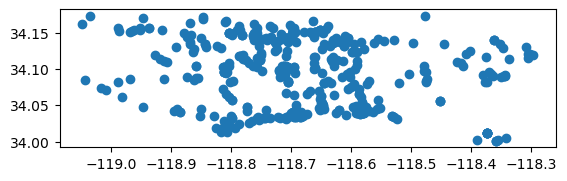

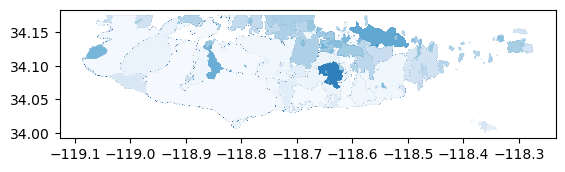

In [16]:
# fire_loc_sm_clip.to_json('/Users/sra/Files/brainstation_2023_ds_capstone/brainstation_2023_ds_capstone/01_capstone_data/shapefiles/locations/fire_loc_sm_clip')

fire_loc_sm_clip.plot()
perim_join.plot("point_elevation", cmap="Blues")  

In [35]:
fire_loc_original.head()

,OBJECTID,SourceOID,ABCDMisc,ADSPermissionState,CalculatedAcres,ContainmentDateTime,ControlDateTime,CreatedBySystem,IncidentSize,DiscoveryAcres,...,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,IsCpxChild,CpxName,CpxID,SourceGlobalID,GlobalID,geometry
0,1,7747595,None,DEFAULT,NaN,None,None,lacocad,NaN,0.10,...,None,None,2020-02-28T20:52:36+00:00,2020-02-28T20:52:36+00:00,0,None,None,{6A311ABB-DF4F-4947-B8DD-3900BDA784F6},{48D2C0E2-5E38-4D40-9D5E-066B076C7D98},POINT (-118.18071 33.80898)
1,2,6384391,None,DEFAULT,NaN,None,None,firecode,NaN,NaN,...,None,None,2019-07-01T20:10:12+00:00,2019-07-01T20:10:12+00:00,0,None,None,{1AF2C949-B159-4D8F-8D39-90CB58BC5DD5},{17D2D66A-D451-4592-A172-7B2C860A2CC9},POINT (-117.15390 33.17639)
2,3,1383752,None,DEFAULT,NaN,None,None,firecode,NaN,NaN,...,None,None,2016-06-20T22:39:02+00:00,2016-06-20T22:39:02+00:00,0,None,None,{1B179EA1-97CE-4699-915B-374754BCBC5B},{60C471FF-3C85-41B4-9135-E7338D7EC90B},POINT (-121.10418 38.83473)
3,4,22499589,None,DEFAULT,NaN,None,None,cfcad,NaN,0.10,...,None,None,2021-11-25T15:24:53+00:00,2021-11-25T15:24:53+00:00,0,None,None,{E61E387B-4ED7-4971-9604-C5D7391FAF77},{149237EC-A42E-43D6-9318-22207A705DD9},POINT (-117.22859 33.78244)
4,5,23869477,None,DEFAULT,NaN,None,None,lacocad,NaN,0.01,...,None,None,2022-11-21T11:28:49+00:00,2022-11-21T11:28:49+00:00,0,None,None,{AEB6F7A3-A109-4132-9FEB-FB1EE1DF3193},{EF7675E3-D5BE-412A-A6C1-0D63FC7153C8},POINT (-118.30903 33.94181)


In [19]:
fire_loc_original.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 250008 entries, 0 to 250007
Data columns (total 96 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   OBJECTID                         250008 non-null  int64   
 1   SourceOID                        250008 non-null  int64   
 2   ABCDMisc                         13005 non-null   object  
 3   ADSPermissionState               250008 non-null  object  
 4   CalculatedAcres                  5350 non-null    float64 
 5   ContainmentDateTime              151258 non-null  object  
 6   ControlDateTime                  136509 non-null  object  
 7   CreatedBySystem                  250008 non-null  object  
 8   IncidentSize                     174298 non-null  float64 
 9   DiscoveryAcres                   185526 non-null  float64 
 10  DispatchCenterID                 212630 non-null  object  
 11  EstimatedCostToDate              14703 non-n

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
fire_loc_sm_clip.head()

,OBJECTID,SourceOID,ABCDMisc,ADSPermissionState,CalculatedAcres,ContainmentDateTime,ControlDateTime,CreatedBySystem,IncidentSize,DiscoveryAcres,DispatchCenterID,EstimatedCostToDate,FinalAcres,FinalFireReportApprovedByTitle,FinalFireReportApprovedByUnit,FinalFireReportApprovedDate,FireBehaviorGeneral,FireBehaviorGeneral1,FireBehaviorGeneral2,FireBehaviorGeneral3,FireCause,FireCauseGeneral,FireCauseSpecific,FireCode,FireDepartmentID,FireDiscoveryDateTime,FireMgmtComplexity,FireOutDateTime,FireStrategyConfinePercent,FireStrategyFullSuppPercent,FireStrategyMonitorPercent,FireStrategyPointZonePercent,FSJobCode,FSOverrideCode,GACC,ICS209ReportDateTime,ICS209ReportForTimePeriodFrom,ICS209ReportForTimePeriodTo,ICS209ReportStatus,IncidentManagementOrganization,IncidentName,IncidentShortDescription,IncidentTypeCategory,IncidentTypeKind,InitialLatitude,InitialLongitude,InitialResponseAcres,InitialResponseDateTime,IrwinID,IsFireCauseInvestigated,IsFireCodeRequested,IsFSAssisted,IsMultiJurisdictional,IsReimbursable,IsTrespass,IsUnifiedCommand,LocalIncidentIdentifier,PercentContained,PercentPerimeterToBeContained,POOCity,POOCounty,POODispatchCenterID,POOFips,POOJurisdictionalAgency,POOJurisdictionalUnit,POOJurisdictionalUnitParentUnit,POOLandownerCategory,POOLandownerKind,POOLegalDescPrincipalMeridian,POOLegalDescQtr,POOLegalDescQtrQtr,POOLegalDescRange,POOLegalDescSection,POOLegalDescTownship,POOPredictiveServiceAreaID,POOProtectingAgency,POOProtectingUnit,POOState,PredominantFuelGroup,PredominantFuelModel,PrimaryFuelModel,SecondaryFuelModel,TotalIncidentPersonnel,UniqueFireIdentifier,WFDSSDecisionStatus,EstimatedFinalCost,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,IsCpxChild,CpxName,CpxID,SourceGlobalID,GlobalID,geometry
162,163,639664,None,DEFAULT,NaN,None,None,firecode,NaN,NaN,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,JG13,None,2014-11-06T15:17:59+00:00,None,None,NaN,NaN,NaN,NaN,None,None,OSCC,None,None,None,None,None,LEONARDO,None,WF,FI,NaN,NaN,NaN,None,{C4EB267D-9C8B-44A9-B899-432392287B11},NaN,0,0.0,0.0,0.0,0.0,NaN,000985,NaN,NaN,None,Los Angeles,None,06037,None,CASMP,None,NPS,Federal,None,None,None,None,NaN,None,None,None,CASMP,US-CA,None,None,None,None,NaN,2014-CASMP-000985,No Decision,NaN,None,None,2014-12-02T22:49:06+00:00,2014-12-02T22:49:26+00:00,0,None,None,{C4EB267D-9C8B-44A9-B899-432392287B11},{80A29F83-DCD9-4874-8779-46D4EE1C938C},POINT (-118.61201 34.13140)
277,278,5055981,None,DEFAULT,NaN,None,None,lacocad,NaN,0.1,CALACC,NaN,NaN,None,None,None,None,None,None,None,Unknown,None,None,None,None,2018-09-28T13:27:40+00:00,None,None,NaN,NaN,NaN,NaN,None,None,OSCC,None,None,None,None,None,LAC-294570,None,WF,FI,34.145910,-118.761200,NaN,None,{FFD17204-016C-4D7A-963F-6066F3739CE2},NaN,0,NaN,NaN,NaN,NaN,NaN,294570,NaN,NaN,None,Los Angeles,CALACC,06037,NPS,CASMP,None,None,None,None,None,None,None,NaN,None,SC08,C&L,CALAC,US-CA,None,None,None,None,NaN,2018-CALAC-294570,No Decision,NaN,None,None,2018-09-28T20:35:01+00:00,2018-09-28T20:35:01+00:00,0,None,None,{FFD17204-016C-4D7A-963F-6066F3739CE2},{B59412DB-B228-445A-A721-211F9BB6560E},POINT (-118.76121 34.14591)
418,419,10510786,None,DEFAULT,0.1,None,None,firecode,0.1,NaN,CAANCC,NaN,NaN,None,None,None,None,None,None,None,Unknown,Cause and Origin Not Identified,None,M8LL,None,2020-07-05T01:18:59+00:00,None,None,NaN,NaN,NaN,NaN,None,None,OSCC,None,None,None,None,None,BRUSH,None,WF,FI,NaN,NaN,NaN,None,{8D0162C0-5B7F-4B34-845B-490375BB3811},NaN,0,0.0,0.0,1.0,0.0,NaN,000153,NaN,NaN,None,Los Angeles,CALACC,06037,C&L,CALAC,None,County,Other,None,None,None,None,NaN,None,SC08,NPS,CASMP,US-CA,Grass,GR2,None,None,NaN,2020-CASMP-000153,No Decision,NaN,None,None,2020-07-05T03:52:49+00:00,2021-02-27T02:11:35+00:00,0,None,None,{8D0162C0-5B7F-4B34-845B-490375BB3811},{B5E81E0F-C783-4BA6-ABAD-21C04FA9F372},POINT (-118.71943 34.09678)
533,534,23842702,None,DEFAULT,NaN,None,None,firecode,NaN,NaN,CAVNCC,NaN,NaN,None,None,None,None,No

<Axes: >

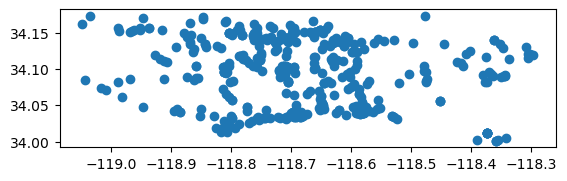

In [11]:
fire_loc_sm_clip.plot()

In [5]:
fire_loc_sm_clip.shape

(464, 96)

In [8]:
print(fire_loc_sm_clip['FireDiscoveryDateTime'].min())
print(fire_loc_sm_clip['FireDiscoveryDateTime'].max())

2014-06-04T00:24:00+00:00
2023-02-20T21:31:04+00:00
